In [16]:
import os
import tarfile
import requests
import shutil
from tqdm import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from random import sample
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
def download_food101(dataset_url, target_path):
    """
    Downloads the Food-101 dataset.
    """
    os.makedirs(target_path, exist_ok=True)
    file_path = os.path.join(target_path, "food-101.tar.gz")

    if not os.path.exists(file_path):
        print(f"Downloading Food-101 dataset to {file_path}...")
        response = requests.get(dataset_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        with open(file_path, 'wb') as f, tqdm(
                desc="Downloading",
                total=total_size,
                unit='B',
                unit_scale=True,
                unit_divisor=1024,
        ) as bar:
            for data in response.iter_content(chunk_size=1024):
                f.write(data)
                bar.update(len(data))

    print("Download complete!")
    return file_path


def extract_food101(file_path, extract_to):
    """
    Extracts the Food-101 dataset.
    """
    print(f"Extracting {file_path} to {extract_to}...")
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=extract_to)
    print("Extraction complete!")



def select_data_subset(split_file, source_dir, target_dir, selected_classes, images_per_class=None):
    """
    Select specific classes and copy their images to a new directory for train/test splits.
    """
    os.makedirs(target_dir, exist_ok=True)

    # Read the split file (train.txt or test.txt)
    with open(split_file, 'r') as f:
        all_images = f.read().splitlines()

    # Filter images for the selected classes
    class_images = {cls: [] for cls in selected_classes}
    for img in all_images:
        cls = img.split('/')[0]
        if cls in selected_classes:
            class_images[cls].append(img)

    # Copy images for each selected class
    for cls, images in class_images.items():
        tgt_class_path = os.path.join(target_dir, cls)
        os.makedirs(tgt_class_path, exist_ok=True)

        if images_per_class:
            images = sample(images, images_per_class)

        for img in images:
            src_path = os.path.join(source_dir, f"{img}.jpg")
            tgt_path = os.path.join(tgt_class_path, os.path.basename(img) + ".jpg")
            shutil.copy(src_path, tgt_path)

In [5]:
# Step 1: Download and Extract the Dataset
dataset_url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
dataset_path = "data101/food-101"

# Download and extract
food101_archive = download_food101(dataset_url, dataset_path)
extract_food101(food101_archive, dataset_path)

Downloading: 100%|██████████| 4.65G/4.65G [1:21:39<00:00, 1.02MB/s] 


Download complete!
Extracting data101/food-101\food-101.tar.gz to data101/food-101...
Extraction complete!


In [10]:
# Step 2: Subset the Dataset for Training and Testing
source_data_dir = os.path.join(dataset_path, "food-101", "images")
train_split_file = os.path.join(dataset_path, "food-101", "meta", "train.txt")
test_split_file = os.path.join(dataset_path, "food-101", "meta", "test.txt")

subset_data_dir = "data10/food-101-10classes"

# Choose 10 classes
selected_classes = [
    "carrot_cake", "chocolate_cake", "sushi", "chicken_wings", "hot_dog", 
    "fried_rice", "greek_salad", "fish_and_chips", "samosa", "ice_cream"
]

# Select data for training (750 images/class by default in Food-101)
select_data_subset(train_split_file, source_data_dir, os.path.join(subset_data_dir, "train"), selected_classes)

# Select data for testing (250 images/class by default in Food-101)
select_data_subset(test_split_file, source_data_dir, os.path.join(subset_data_dir, "test"), selected_classes)

In [11]:
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

In [12]:
# data augmentation
# create a train transformation

train_transform = transforms.Compose([
    # resize the image to 256X256
    transforms.Resize(size=(256, 256)),
    
    # flip the image randomly on the horizontal axis
    #transforms.RandomHorizontalFlip(p=0.5),
    
    #transforms.RandomRotation(10),
    # #transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    # resize the image to 256X256
    transforms.Resize(size=(256, 256)),
    
    # turn the image into torch.Tensor
    transforms.ToTensor()
])

In [13]:
train_dataset = datasets.ImageFolder(root=os.path.join(subset_data_dir, "train"), 
                                    transform=train_transform)

test_dataset = datasets.ImageFolder(root=os.path.join(subset_data_dir, "test"), 
                                    transform=test_transform)

In [36]:
len(train_dataset), len(test_dataset)

(7500, 2500)

In [14]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
# setup the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
train_dataset.classes

['carrot_cake',
 'chicken_wings',
 'chocolate_cake',
 'fish_and_chips',
 'fried_rice',
 'greek_salad',
 'hot_dog',
 'ice_cream',
 'samosa',
 'sushi']

In [20]:
len(train_loader), len(test_loader)

(235, 79)

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights

In [ ]:

class FoodModel(nn.Module):
    def __init__(self, output_classes, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Load the pretrained ResNet18 model
        # self.base_model = models.resnet18(pretrained=True) -> deprecated 
        self.base_model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Updated to use weights
        
        # Remove the fully connected layer from ResNet18
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-2])  # Keep the spatial dimensions (8x8)

        for param in self.base_model.parameters():
            param.requires_grad = True

        # Custom convolutional layers
        self.custom_layers = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Conv1-512
            nn.ReLU(),
            nn.Conv2d(512, 32, kernel_size=3, padding=1),   # Conv2-32
            nn.ReLU(),
            nn.Conv2d(32, 6, kernel_size=3, padding=1),     # Conv3-6
            nn.ReLU()
        )

        # Fully connected layer
        self.flatten = nn.Flatten()
        # Dynamically calculate the input size to the fully connected layer
        self.fc = nn.Linear(6 * 8 * 8, output_classes)

    def forward(self, x):
        x = self.base_model(x)  # Pass through ResNet18 (Output: [B, 512, 8, 8])
        x = self.custom_layers(x)  # Pass through custom conv layers (Output: [B, 6, 8, 8])
        x = self.flatten(x)  # Flatten (Output: [B, 6 * 8 * 8])
        x = self.fc(x)  # Fully connected layer (Output: [B, output_classes])
        return x

In [28]:
model = FoodModel(
    output_classes=len(train_dataset.classes)
).to(device)

In [29]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [30]:
from torchinfo import summary

summary(model, input_size=[1, 3, 256, 256])

Layer (type:depth-idx)                        Output Shape              Param #
FoodModel                                     [1, 10]                   --
├─Sequential: 1-1                             [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                            [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                       [1, 64, 128, 128]         128
│    └─ReLU: 2-3                              [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                         [1, 64, 64, 64]           --
│    └─Sequential: 2-5                        [1, 64, 64, 64]           --
│    │    └─BasicBlock: 3-1                   [1, 64, 64, 64]           73,984
│    │    └─BasicBlock: 3-2                   [1, 64, 64, 64]           73,984
│    └─Sequential: 2-6                        [1, 128, 32, 32]          --
│    │    └─BasicBlock: 3-3                   [1, 128, 32, 32]          230,144
│    │    └─BasicBlock: 3-4                   [1, 128, 32, 32]          295,42

In [31]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [32]:

def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                train_loss_accum: list,
                train_acc_accum: list,
                device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_logit = model(X)
        
        y_proba = torch.softmax(y_logit, dim=1)
        y_pred = y_proba.argmax(dim=1)

        # 2. Calculate loss
        loss = loss_fn(y_logit, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    train_loss_accum.append(train_loss.item())
    train_acc_accum.append(train_acc/100.0)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    

def test_step(data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                test_loss_accum: list,
                test_acc_accum: list,
                device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_logit = model(X)
            test_proba = torch.softmax(test_logit, dim=1)
            test_pred = test_proba.argmax(dim=1)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_logit, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        test_loss_accum.append(test_loss.item())
        test_acc_accum.append(test_acc/100.0)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [33]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    
    return total_time

In [37]:
from tqdm.auto import tqdm # type: ignore

# Measure time
from timeit import default_timer as timer
train_time_start_model = timer()

model = FoodModel(
    output_classes=len(train_dataset.classes)
).to(device)

# Train and test model 
epochs = 6

# list to store train and test loss, accuracy
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                        betas=(0.9, 0.999),
                        lr=0.0001)

# optimizer = torch.optim.SGD(params=model_0.parameters(),
#                         lr=0.1)

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_loader, 
        model=model, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        train_loss_accum=train_losses,
        train_acc_accum=train_accuracies,
        device=device
    )
    
    test_step(data_loader=test_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        test_loss_accum=test_losses,
        test_acc_accum=test_accuracies,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                        end=train_time_end_model,
                                        device=device)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.04072 | Train accuracy: 64.15%
Test loss: 0.41731 | Test accuracy: 87.14%

Epoch: 1
---------
Train loss: 0.54812 | Train accuracy: 82.41%
Test loss: 0.42763 | Test accuracy: 86.35%

Epoch: 2
---------
Train loss: 0.30589 | Train accuracy: 90.11%
Test loss: 0.76943 | Test accuracy: 80.14%

Epoch: 3
---------
Train loss: 0.20920 | Train accuracy: 93.28%
Test loss: 0.47620 | Test accuracy: 86.16%

Epoch: 4
---------
Train loss: 0.16892 | Train accuracy: 94.57%
Test loss: 0.46923 | Test accuracy: 84.65%

Epoch: 5
---------
Train loss: 0.13562 | Train accuracy: 95.73%
Test loss: 0.42716 | Test accuracy: 88.81%

Train time on cuda: 508.564 seconds


In [38]:
from utils import plot_training_history

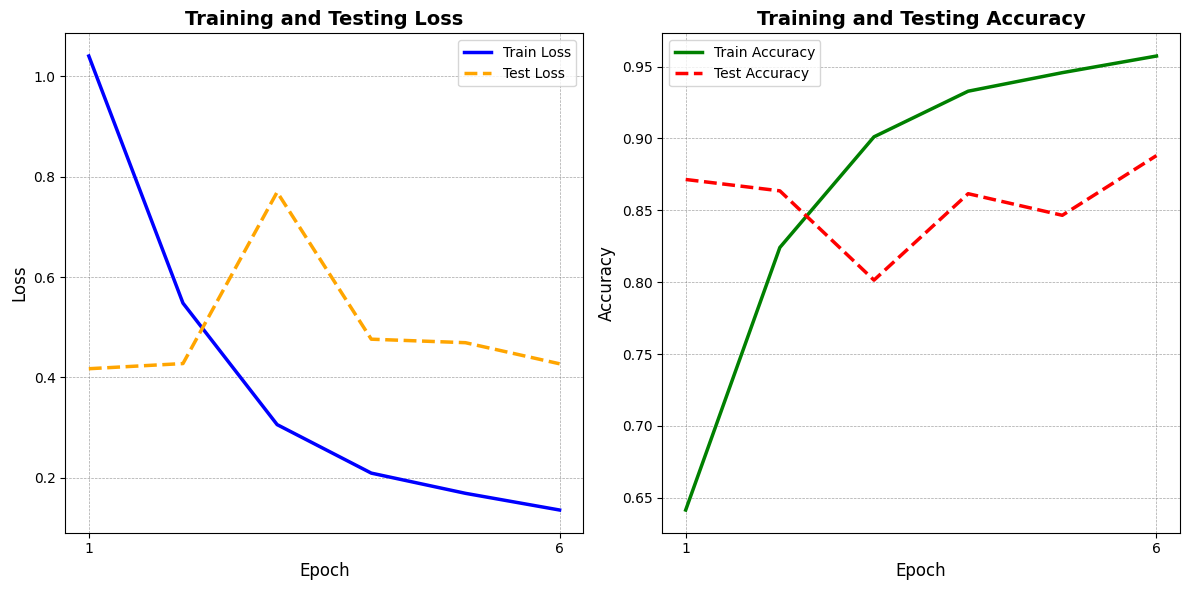

In [39]:
plot_training_history(
    epochs=epochs,
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)